# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd

import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


array([[<Axes: title={'center': 'calls'}>,
        <Axes: title={'center': 'minutes'}>],
       [<Axes: title={'center': 'messages'}>,
        <Axes: title={'center': 'mb_used'}>],
       [<Axes: title={'center': 'is_ultra'}>, <Axes: >]], dtype=object)

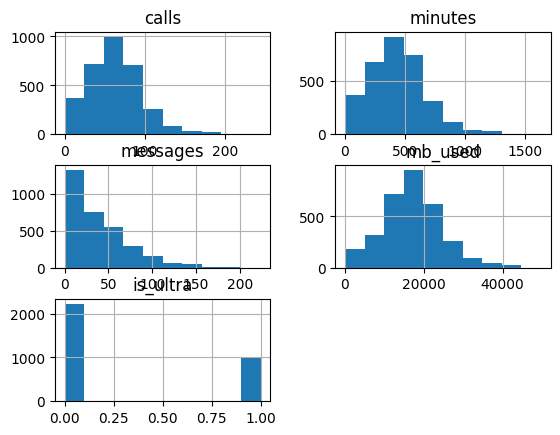

In [3]:
data.hist()

Проверим данные на мультиколлинеарность.

In [4]:
for i in range(len(data.columns[:-1]) - 1):
    for j in range(i + 1, len(data.columns[:-1])):
        print('corr', data.columns[i], data.columns[j], data[data.columns[i]].corr(data[data.columns[j]]))
    

corr calls minutes 0.9820832355742292
corr calls messages 0.17738450121769542
corr calls mb_used 0.2864415120350544
corr minutes messages 0.1731102258096908
corr minutes mb_used 0.28096693508821474
corr messages mb_used 0.1957211209558215


In [5]:
data.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


В данных имеется мультиколлинеарность по параметрам 'calls' и 'minutes', для устранения этой проблемы удалим из датасета параметр 'calls'.

In [6]:
data = data.drop('calls', axis=1)

Посмотрим как распределены параметры в зависимости от целевого признака.

/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


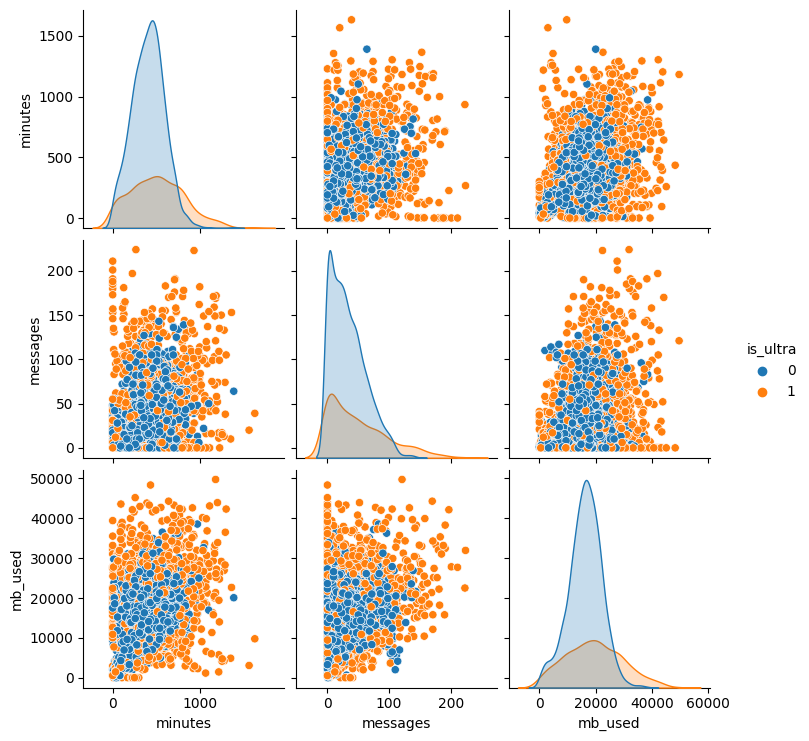

In [7]:
sns.pairplot(data, hue="is_ultra")

Изимеющихся данных видно, что признаки 'minutes', 'messages' и 'mb_used' распределены похожим образом на обоих тарифах, но пользователей в тарифом "Ультра" значительно меньше. 

## Разбейте данные на выборки

Выделим по 20% датасета на тестовые и валидационные выборки. 

In [8]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.2)

features_train, features_valid, target_train, target_valid = \
train_test_split(features_train, target_train, test_size=0.25)

for i in [features_train, features_valid, target_train, target_valid, target_train, target_test]:
    print(i.shape) 

(1928, 3)
(643, 3)
(1928,)
(643,)
(1928,)
(643,)


## Исследуйте модели

### Дерево решений

In [9]:
best_result = 0

for depth in range (1, 101):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)\
    .fit(features_train, target_train)
    
    result = accuracy_score(target_valid, model.predict(features_valid))
    
    if result > best_result:
        best_result = result
        best_depth = depth
        best_tree_model = model
        
print('Точность лучшей модели дерева решений', best_result)
print('Глубина модели', best_depth)

Точность лучшей модели дерева решений 0.7884914463452566
Глубина модели 4


### Случайный лес

In [10]:
best_result = 0

for forest in range(10, 101, 10):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=1, n_estimators=forest, max_depth=depth)\
        .fit(features_train, target_train)
    
        result = accuracy_score(target_valid, model.predict(features_valid))
    
        if result > best_result:
            best_result = result
            best_forest = forest
            best_depth = depth
            best_forest_model = model

print('Точность лучшей модели случайного леса', best_result)
print('Количество деревьев', best_forest)
print('Глубина модели', best_depth)

Точность лучшей модели случайного леса 0.80248833592535
Количество деревьев 100
Глубина модели 10


### Логистическая регрессия

In [11]:
model = LogisticRegression().fit(features_train, target_train)
result = accuracy_score(target_valid, model.predict(features_valid))

print('Точность модели логистической регрессии', result)

Точность модели логистической регрессии 0.7216174183514774


Из полученных результатов видно, модель дерева решений и модель случайного леса лучше модели логистической регрессии и показывают примерно одинаковые результаты, но модель дерева решений требует значительно меньших ресурсов, а значит будет быстрее работать, поэтому именно её мы будем использовать для проверки на тестовой выборке.

## Проверьте модель на тестовой выборке

In [12]:
accuracy_score(target_test, best_tree_model.predict(features_test))

0.7884914463452566

## (бонус) Проверьте модели на адекватность

In [13]:
best_tree_model.predict(features_test)

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Полученная модель представляет собой последовательно нулей и единиц и таким образом выполняет классификацию по признаку подключения тарифа "Ультра", более того, как мы выяснили ранее, точность прогнозирования на тестовой выборке достигла целевого значения, а значит модель является адекватной.

Посмотрим также на результаты, которые покажет baseline-модель. 

In [14]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=1)\
.fit(features_train, target_train)

dummy_model.score(features_test, target_test)

0.6967340590979783

Результаты baseline-модели значительно хуже, а значит применение более сложных и ресурсозатратных моделей было оправдано.

## Выводы
Для прогнозирования клиентов, которые могут перейти с архивных тарифов на тариф "Ультра" были и построены и протестированы следующие модели классификации:
1. Модель дерева решений с глубиной от 1 до 10, наилучший результат показала модель с глубиной 7.
2. Модель случайного  леса получила аналогичный результат с количеством деревьев 40 и глубиной модели 8, эта модель существенно проигрывает первой в быстродействии.
3. Модель логистической регрессии показала результаты хуже чем предыдущие две.

Выбранная в результате модель была проверена на тестовой выборке, не участвовавшей в обучении моделей, получила результаты точности на целевом уровне и выдаёт адекватные результаты.